In [161]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, euclidean_distances
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [162]:
# Load Iris dataset
iris = load_iris()
data = iris.data
labels = iris.target
n_data = len(data)

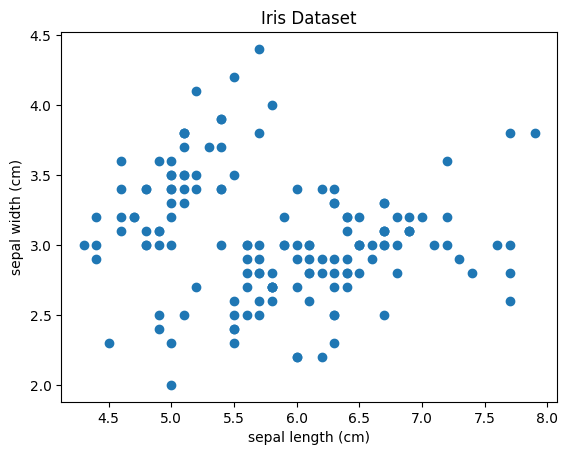

(150, 4)

In [163]:
plt.scatter(data[:, 0], data[:, 1])
plt.title('Iris Dataset')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()
data.shape

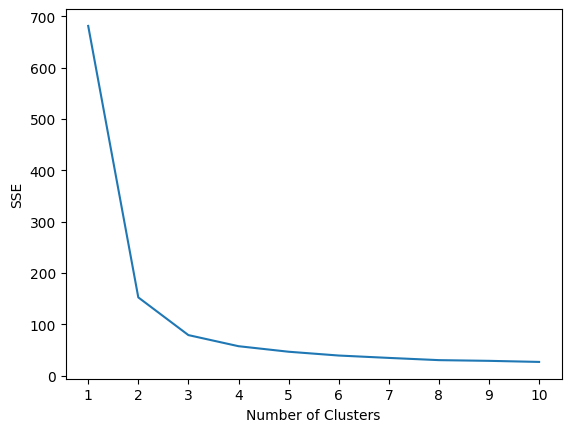

In [164]:
# Elbow method
# initialize kmeans parameters

# create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

# visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [165]:
n_clusters = 3

In [166]:
# Crossover function
def crossover(parent1, parent2):
    # Generate two random crossover points within the range of the parents lengths
    crossover_point1 = np.random.randint(1, len(parent1) - 1)
    crossover_point2 = np.random.randint(1, len(parent1) - 1)

    # Determine the left and right boundaries for the crossover segment
    l = min(crossover_point1, crossover_point2)
    r = max(crossover_point1, crossover_point2)

    # Create children by combining segments of parent1 and parent2
    child1 = np.concatenate((parent1[:l], parent2[l:r], parent1[r:]))
    child2 = np.concatenate((parent2[:l], parent1[l:r], parent2[r:]))

    # Return the two resulting children
    return child1, child2


In [167]:
# Mutation function
def mutation(chromosome, radius):
    # Create a copy of the original chromosome
    mutated_chromosome = chromosome.copy()
    
    # Choose a random index for mutation
    mutation_i = np.random.randint(n_data - 1)
    
    # Find the data point with the least distance 
    # from mutated point within the 'radius'
    minimum = float('inf')
    index = -1
    l = max(0, mutation_i - radius)
    r = min(n_data - 1, mutation_i + radius)
    for i in range(l, r):
        if i == mutation_i:
            continue
        dist = euclidean_distances(data[mutation_i].reshape(1, -1), data[i].reshape(1, -1))
        if  dist < minimum:
            minimum = dist
            index = i
    
    # Replace the mutated point label with its nearest neighbor in the 'radius'
    mutated_chromosome[mutation_i] = chromosome[index]
    
    return mutated_chromosome

In [168]:
# Objective function: Calculate silhouette score
def objective_function(chromosome):
    labels_pred = chromosome.astype(int)
    silhouette_avg = silhouette_score(data, labels_pred)
    return -silhouette_avg  # Negative because we want to minimize (convert silhouette score to a minimization problem)

In [169]:
# Function to initialize seeds for the genetic algorithm population
def heuristic_seed():
    # Initialize an empty list to store centroids
    centroids = []

    # Select a random data point as the first centroid
    centroids.append(data[np.random.randint(data.shape[0]), :])

    # seed chromosome
    seed = np.zeros(n_data)

    # Iterate to find the remaining centroids
    for _ in range(n_clusters - 1):
        dist = []
        # Calculate distances for each data point to it's nearest centroid
        for i in range(data.shape[0]):
            point = data[i]
            d = float('inf')
            for j in range(len(centroids)):
                temp_dist = euclidean_distances(point.reshape(1, -1), centroids[j].reshape(1, -1))
                d = min(d, temp_dist)

            dist.append(d)

        dist = np.array(dist)
        # Select the data point with the maximum distance
        # from current centroids as the next centroid
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)

        # Assign cluster labels based on the nearest centroid for each data point
        for i in range(data.shape[0]):
            point = data[i]
            d = float('inf')

            # Iterate through existing centroids to find the nearest one
            for j in range(len(centroids)):
                temp_dist = euclidean_distances(point.reshape(1, -1), centroids[j].reshape(1, -1))
                if temp_dist < d:
                    d = temp_dist
                    seed[i] = j

    # Return the array of assigned clusters
    return seed


In [170]:
# Number of generations and population size
num_generations = 200
population_size = 150

In [171]:
# Initialize population
population = np.random.randint(0, n_clusters, size=(population_size, n_data))
population[0] = heuristic_seed()

In [172]:
# Main loop
for generation in range(num_generations):
    # Evaluate fitness (objective) for each chromosome in the population
    fitness = np.array([objective_function(chromosome) for chromosome in population])
    

    # Select the top 50% of the population based on fitness for reproduction
    selected_indices = np.argsort(fitness)[:population_size//2]
    selected_population = population[selected_indices]


    # Crossover: Pairwise crossover among selected chromosomes
    children = []
    for i in range(0, len(selected_population)-1, 2):
        child1, child2 = crossover(selected_population[i], selected_population[i+1])
        children.extend([child1, child2])

    # Mutation: Apply mutation to some of the children
    mutation_rate = 0.5
    num_mutations = int(mutation_rate * len(children))
    mutation_indices = np.random.choice(range(len(children)), size=num_mutations, replace=False)
    for index in mutation_indices:
        children[index] = mutation(children[index], 5)

    # Replace old population with the combined population of selected individuals and children
    population = np.vstack((selected_population, children))

In [173]:
# Select the best chromosome from the final population
best_chromosome = population[np.argmin(fitness)]

# Extract the best labels from the best chromosome
y_pred_GA = best_chromosome.astype(int)

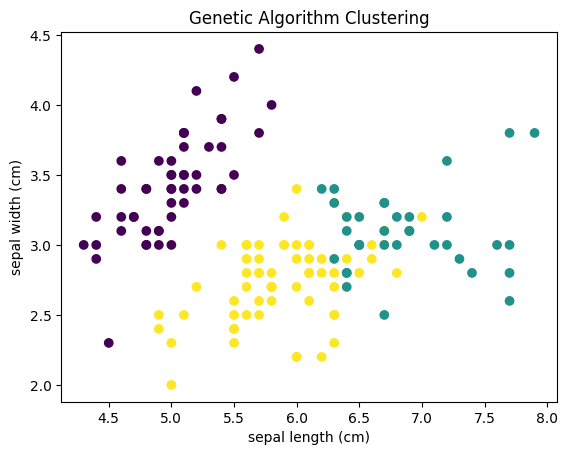

In [174]:
plt.scatter(data[:, 0], data[:, 1], c=y_pred_GA)
plt.title('Genetic Algorithm Clustering')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

In [175]:
GA_score = silhouette_score(data, y_pred_GA)
print(f'silhouetter score Genetic Algorithm: {GA_score}')

silhouetter score Genetic Algorithm: 0.5553062646081594


In [250]:
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(data)
y_pred_kmeans = kmeans.labels_

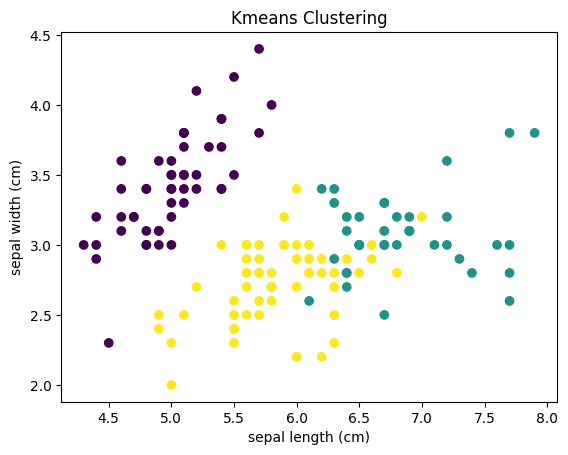

In [251]:
plt.scatter(data[:, 0], data[:, 1], c=y_pred_kmeans)
plt.title('Kmeans Clustering')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

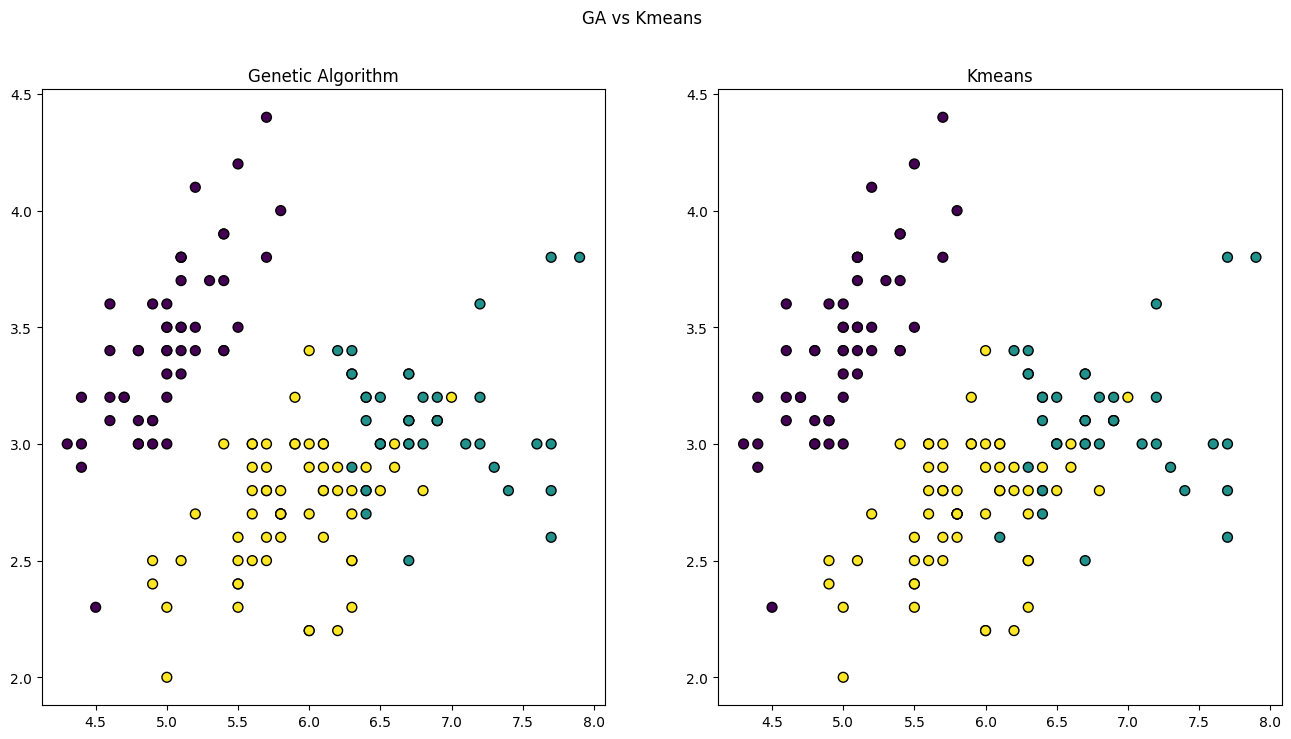

In [252]:
# GA vs Kmeans
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(data[:, 0], data[:, 1], c=y_pred_GA, cmap='viridis', edgecolor='k', s=50)
ax[1].scatter(data[:, 0], data[:, 1], c=y_pred_kmeans, cmap='viridis', edgecolor='k', s=50)
fig.suptitle('GA vs Kmeans')
ax[0].set_title('Genetic Algorithm')
ax[1].set_title('Kmeans')
plt.show()

In [253]:
# Comparing Genetic algorithm and Kmeans performance

# GA score
GA_score = silhouette_score(data, y_pred_GA)
print(f'silhouetter score Genetic Algorithm: {GA_score: .2f}')

# Kmeans score
kmeans_score = silhouette_score(data, y_pred_kmeans)
print(f'silhouetter score Kmeans: {kmeans_score: .2f}')

silhouetter score Genetic Algorithm:  0.56
silhouetter score Kmeans:  0.55
